<a href="https://colab.research.google.com/github/matin/garth/blob/main/colabs/stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Garmin stress statistics

## Setup

Start by installing and importing `garth`

In [1]:
!pip install -q garth

In [2]:
import garth

Define Garth session location to save and resume sessions

In [3]:
SESSION_PATH = 'drive/MyDrive/garth'

Mount Drive for saving and resuming sessions

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Resume session or login, and make sure to save the garth session for next time

In [ ]:
from garth.exc import GarthException
from getpass import getpass
from requests import HTTPError

try:
    garth.resume(SESSION_PATH)
    garth.client.auth_token.refresh()
except (GarthException, HTTPError, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(SESSION_PATH)

## Weekly stress

Retrieve the weekly stress averages by year. The most we can retrieve at one time is 52 weeks.

In [6]:
from datetime import date, timedelta

start = date.today()
stress = []
while annual := garth.connectapi(
        f'/usersummary-service/stats/stress/weekly/{start}/52'
):
    stress += annual
    start -= timedelta(weeks=52)

Let's see what Garmin sent us

In [7]:
stress[0]

{'calendarDate': '2022-07-22', 'value': 25}

Use pandas and matplotlib to graph

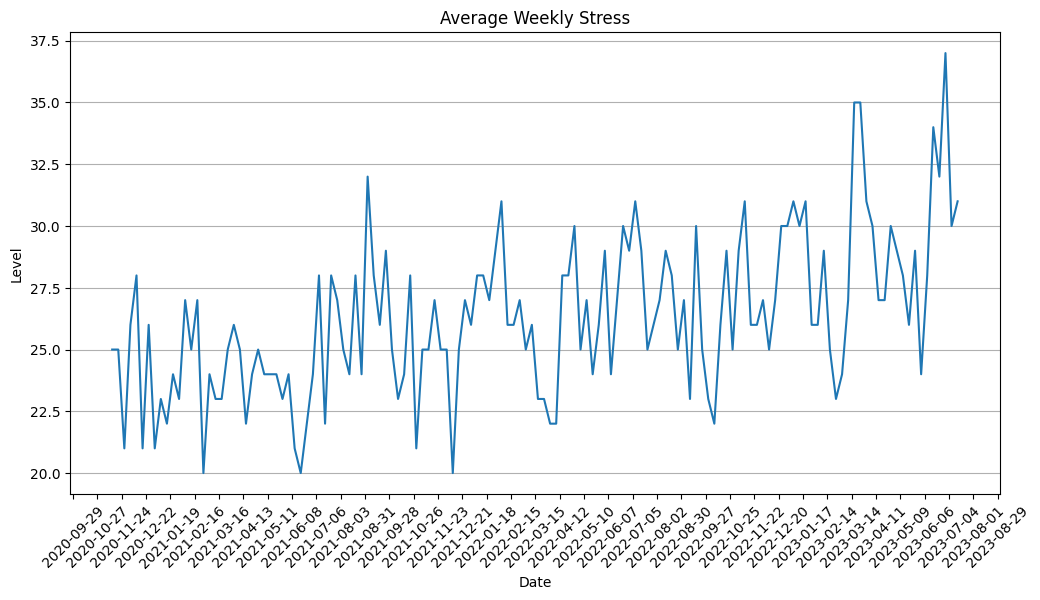

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.DataFrame(stress).sort_values('calendarDate')

# Convert the dates from string to datetime format
df['calendarDate'] = pd.to_datetime(df['calendarDate'])

# Plot the data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df['calendarDate'], df['value'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))  # set x-ticks to every 4 weeks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # format x-ticks as YYYY-MM-DD
plt.xlabel('Date')
plt.ylabel('Level')
plt.title('Average Weekly Stress')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

## Daily stress

Retrieve daily averages by week. This takes a while to run.

---



In [9]:
daily_stress = []
day = date.today()
while daily := garth.connectapi(
        "/usersummary-service/stats/stress/daily/"
        f"{day - timedelta(days=6)}/{day}"
    ):
    daily_stress += daily
    day -= timedelta(days=7)

Let's see what Garmin sent us

In [10]:
daily_stress[0]

{'calendarDate': '2023-07-14',
 'values': {'highStressDuration': 6000,
  'lowStressDuration': 15660,
  'overallStressLevel': 38,
  'restStressDuration': 27360,
  'mediumStressDuration': 9480}}

We have to flatten that to properly create a DataFrame with it

In [11]:
daily_stress = [day | day.pop('values') for day in daily_stress]
daily_stress[0]

{'calendarDate': '2023-07-14',
 'highStressDuration': 6000,
 'lowStressDuration': 15660,
 'overallStressLevel': 38,
 'restStressDuration': 27360,
 'mediumStressDuration': 9480}

Daily stats are going to have a *lot* of noise, so let's also graph the smoothed 28-day rolling average

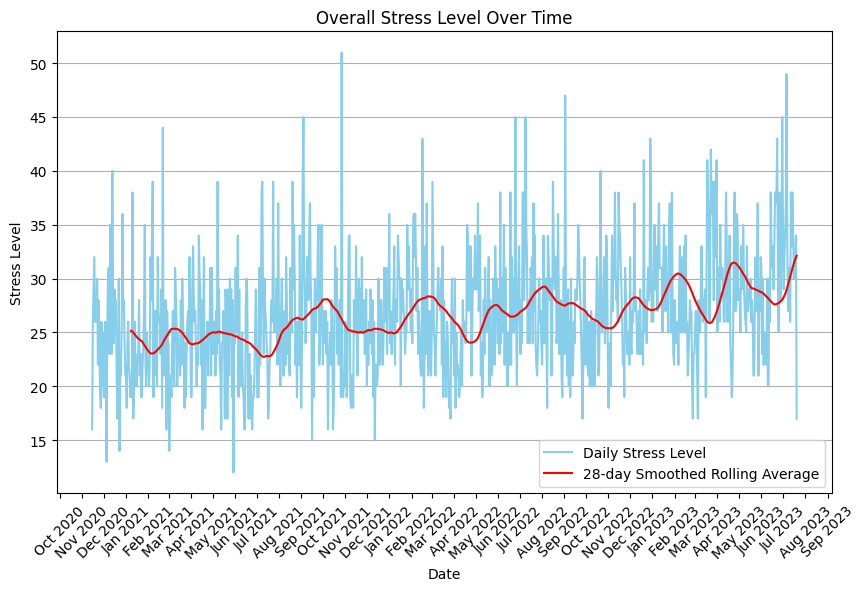

In [12]:
# Load the data into a DataFrame
df = pd.DataFrame(daily_stress).sort_values('calendarDate')

# Convert the 'calendarDate' column to datetime
df['calendarDate'] = pd.to_datetime(df['calendarDate'])

# Set 'calendarDate' as the DataFrame index
df.set_index('calendarDate', inplace=True)

# Calculate the rolling average
df['rolling_avg'] = df['overallStressLevel'].rolling(window=28).mean()

# For smoother rolling average you could apply the rolling mean again (not common approach)
df['rolling_avg_smooth'] = df['rolling_avg'].rolling(window=28).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(10,6))

# Plot 'overallStressLevel' and 'rolling_avg'
ax.plot(df.index, df['overallStressLevel'], color='skyblue', label='Daily Stress Level')  # Change color to 'skyblue'
ax.plot(df.index, df['rolling_avg_smooth'], color='r', label='28-day Smoothed Rolling Average')

# Format the x-axis to show the month and year only
ax.xaxis.set_major_locator(mdates.MonthLocator())  # set x-ticks to every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format x-ticks as Month-Year

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Stress Level')
plt.title('Overall Stress Level Over Time')
plt.grid(True, axis='y')  # Only display y-axis grid lines
plt.legend()  # Show the legend

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.show()